In [5]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
# The typo was in this line. 'train_test_spilt' should be 'train_test_split'
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier #Also corrected a typo here
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold #Also corrected a typo here
# 'metrices' should be 'metrics' and it does not have classification_report or accuracy_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [6]:
df = pd.read_csv('/content/archive.zip')
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [8]:
continuous_feature = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

features_to_convert = [feature for feature in df.columns if feature not in continuous_feature]

df[features_to_convert] = df[features_to_convert].astype('object')

df.dtypes

,0
age,int64
sex,object
cp,object
trestbps,int64
chol,int64
fbs,object
restecg,object
thalach,int64
exang,object
oldpeak,float64


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1025.0,54.434146,9.072290,29.0,48.0,56.0,61.0,77.0
trestbps,1025.0,131.611707,17.516718,94.0,120.0,130.0,140.0,200.0
chol,1025.0,246.000000,51.592510,126.0,211.0,240.0,275.0,564.0
thalach,1025.0,149.114146,23.005724,71.0,132.0,152.0,166.0,202.0
oldpeak,1025.0,1.071512,1.175053,0.0,0.0,0.8,1.8,6.2


In [10]:
df.describe(include='object')

,sex,cp,fbs,restecg,exang,slope,ca,thal,target
count,1025,1025,1025,1025,1025,1025,1025,1025,1025
unique,2,4,2,3,2,3,5,4,2
top,1,0,0,1,0,1,0,2,1
freq,713,497,872,513,680,482,578,544,526


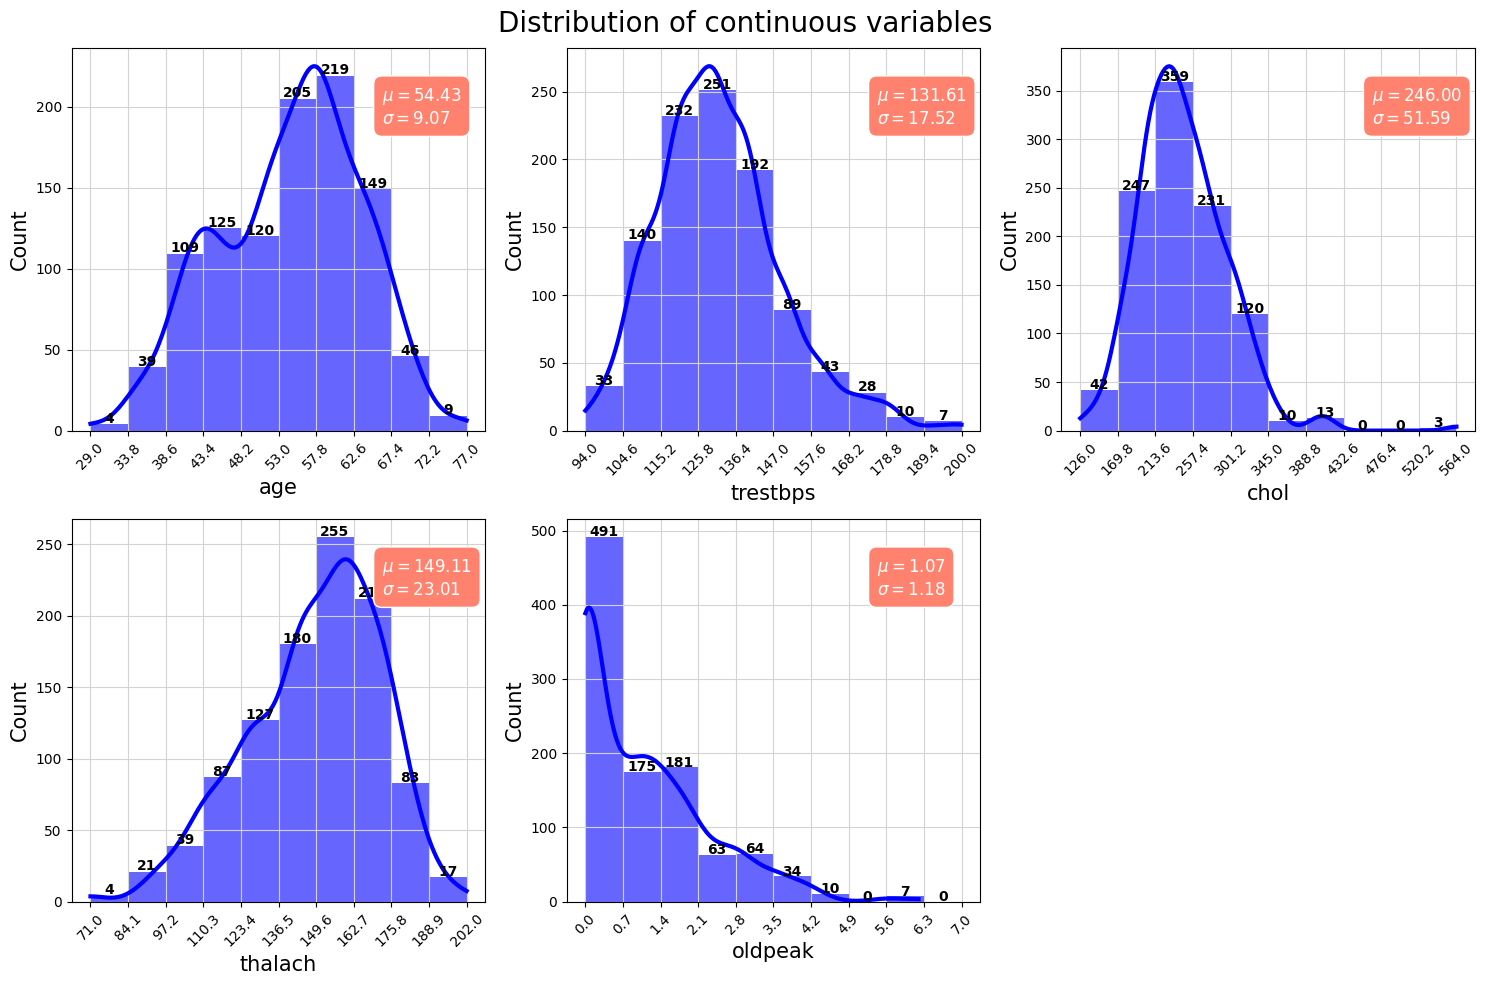

In [11]:
# first i perform univariate Analysis
df_continuous = df[continuous_feature]

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10)) # Corrected 'nclose' to 'ncols'
for i, col in enumerate(df_continuous.columns):
    x = i // 3
    y = i % 3
    # Corrected the range argument in np.histogram
    values, bin_edges = np.histogram(df_continuous[col],
                                      range=(np.floor(df_continuous[col].min()), np.ceil(df_continuous[col].max())))

    graph = sns.histplot(data=df_continuous, x=col, bins=bin_edges, kde=True, ax=ax[x, y],
                        edgecolors='none', color='blue', alpha=0.6, line_kws={'lw': 3})
    ax[x, y].set_xlabel(col, fontsize=15) # Corrected 'frontsize' to 'fontsize'
    ax[x, y].set_ylabel('Count', fontsize=15)
    ax[x, y].set_xticks(np.round(bin_edges, 1))
    # Corrected 'set_xtrickslabels' to 'set_xticklabels' and 'get_tricks' to 'get_xticks'
    ax[x, y].set_xticklabels(ax[x, y].get_xticks(), rotation=45)
    ax[x, y].grid(color='lightgrey')

    for j, p in enumerate(graph.patches):
        ax[x, y].annotate('{}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 1),
                           ha='center', fontsize=10, fontweight="bold")

    textstr = '\n'.join((
        r'$\mu=%.2f$' % df_continuous[col].mean(),
        r'$\sigma=%.2f$' % df_continuous[col].std()
    ))
    ax[x, y].text(0.75, 0.9, textstr, transform=ax[x, y].transAxes, fontsize=12, verticalalignment='top',
                  color='white', bbox=dict(boxstyle='round', facecolor='#ff826e', edgecolor='white', pad=0.5))
ax[1, 2].axis('off') # Moved this line outside the loop
plt.suptitle('Distribution of continuous variables', fontsize=20) # Corrected 'frontsize' to 'fontsize'
plt.tight_layout()
plt.show()

categorical Variables Univariate Analysis

In [12]:
Categorical_feature = df.columns.difference(continuous_feature) # Changed continuous_features to continuous_feature
df_categorical = df[Categorical_feature]

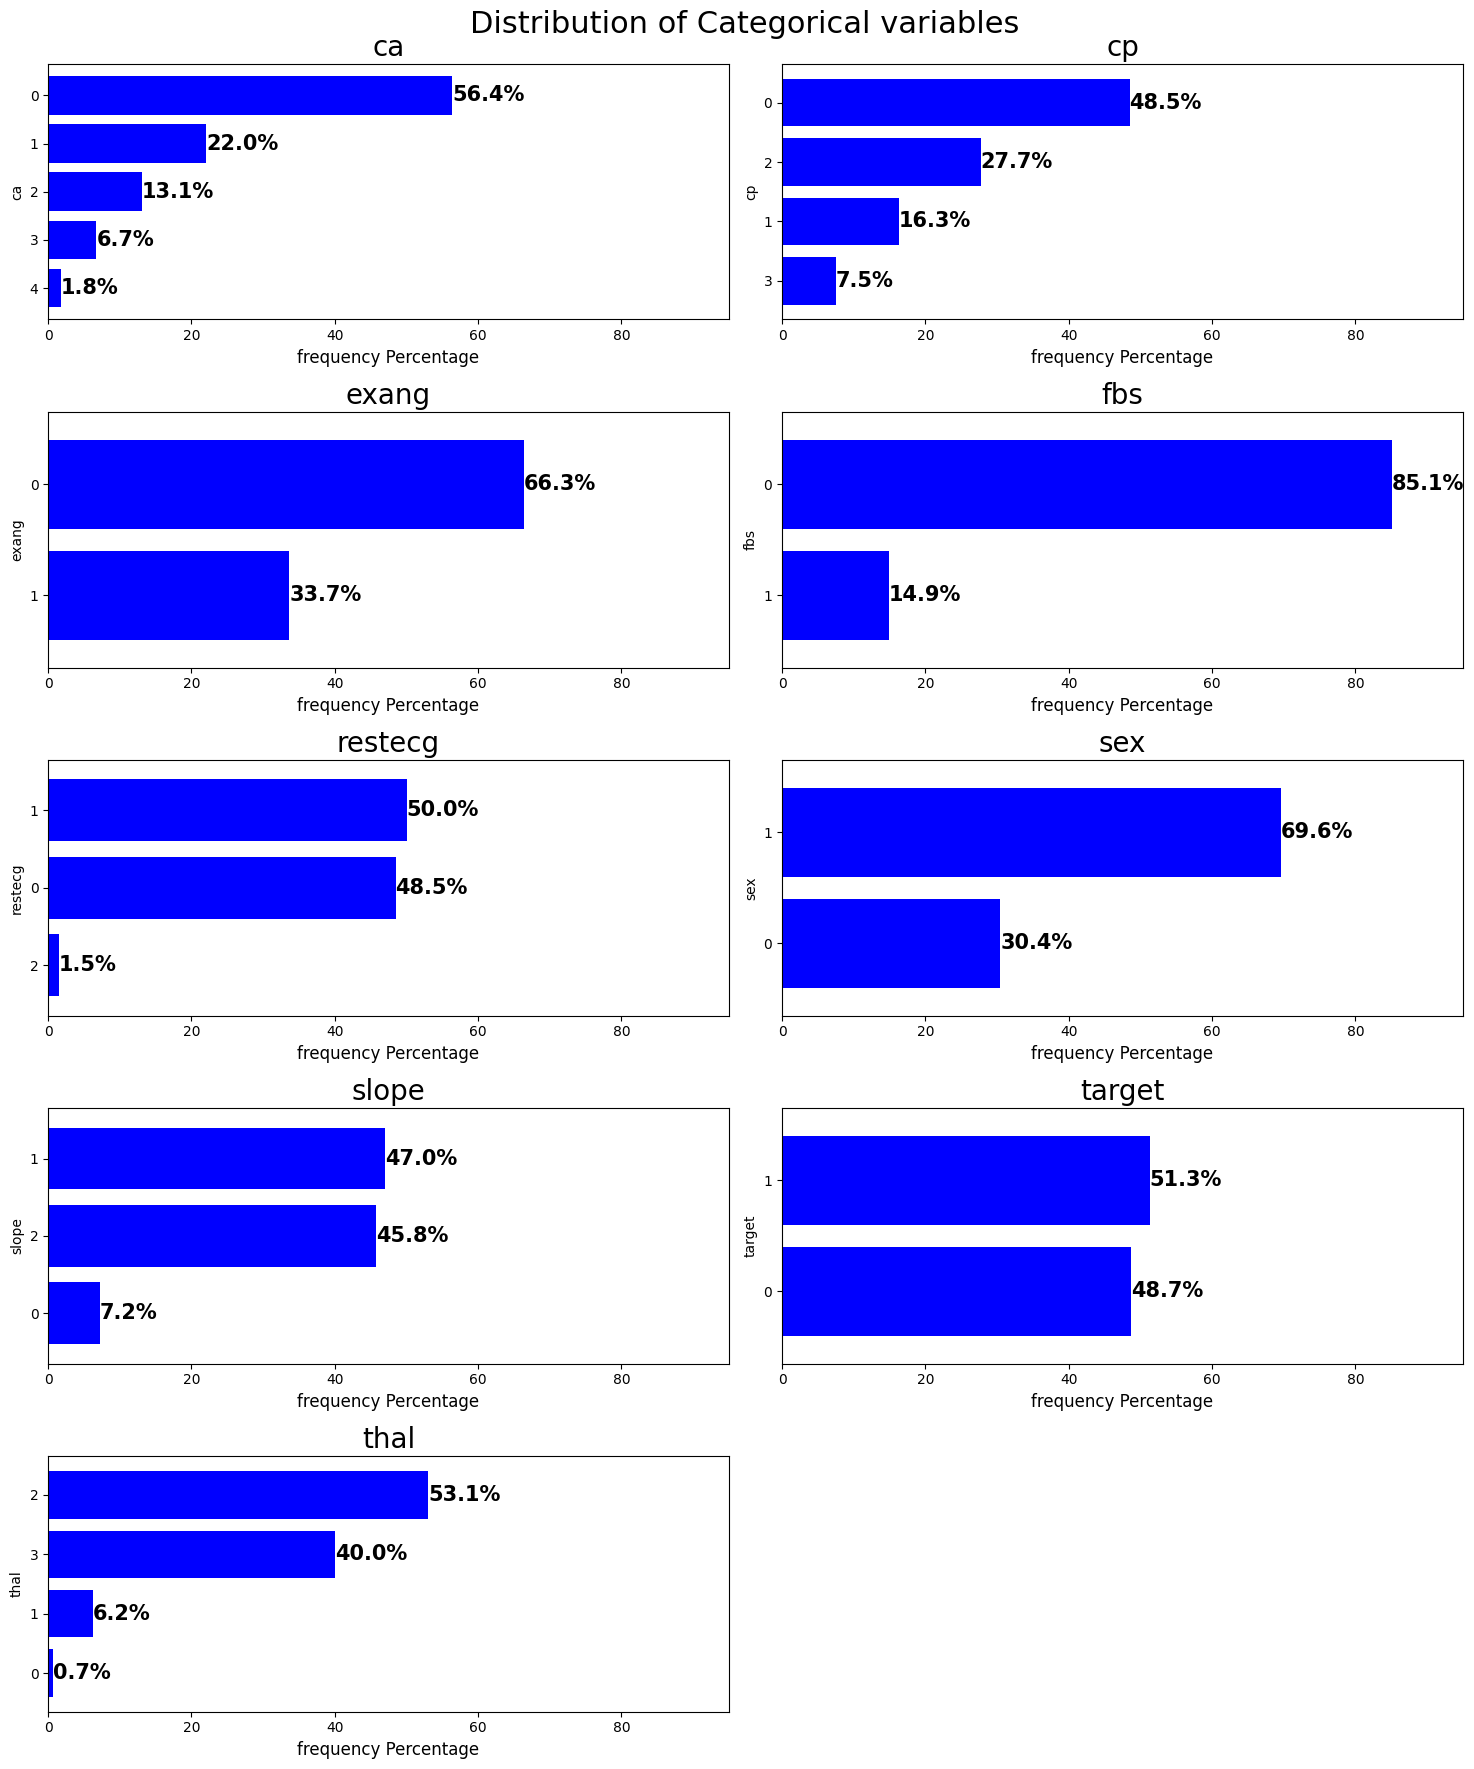

In [13]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 18)) # Corrected 'nclose' to 'ncols'

for i, col in enumerate(Categorical_feature):
    row = i // 2
    col_idx = i % 2


    value_counts = df[col].value_counts(normalize=True).mul(100).sort_values()


    value_counts.plot(kind='barh', ax=ax[row, col_idx], width=0.8, color='blue')

    for index, value in enumerate(value_counts):
        ax[row, col_idx].text(value, index, str(round(value, 1)) + '%', fontsize=15, weight='bold', va='center')

    ax[row, col_idx].set_xlim([0, 95]) # Corrected indentation here
    ax[row, col_idx].set_xlabel('frequency Percentage', fontsize=12) # Corrected indentation here
    ax[row, col_idx].set_title(f'{col}', fontsize=20) # Corrected indentation here

ax[4,1].axis('off') # Corrected indentation here, moved outside the inner loop
plt.suptitle('Distribution of Categorical variables', fontsize=22) # Corrected indentation here
plt.tight_layout() # Corrected indentation here
plt.subplots_adjust(top=0.95) # Corrected indentation here
plt.show() # Corrected indentation here

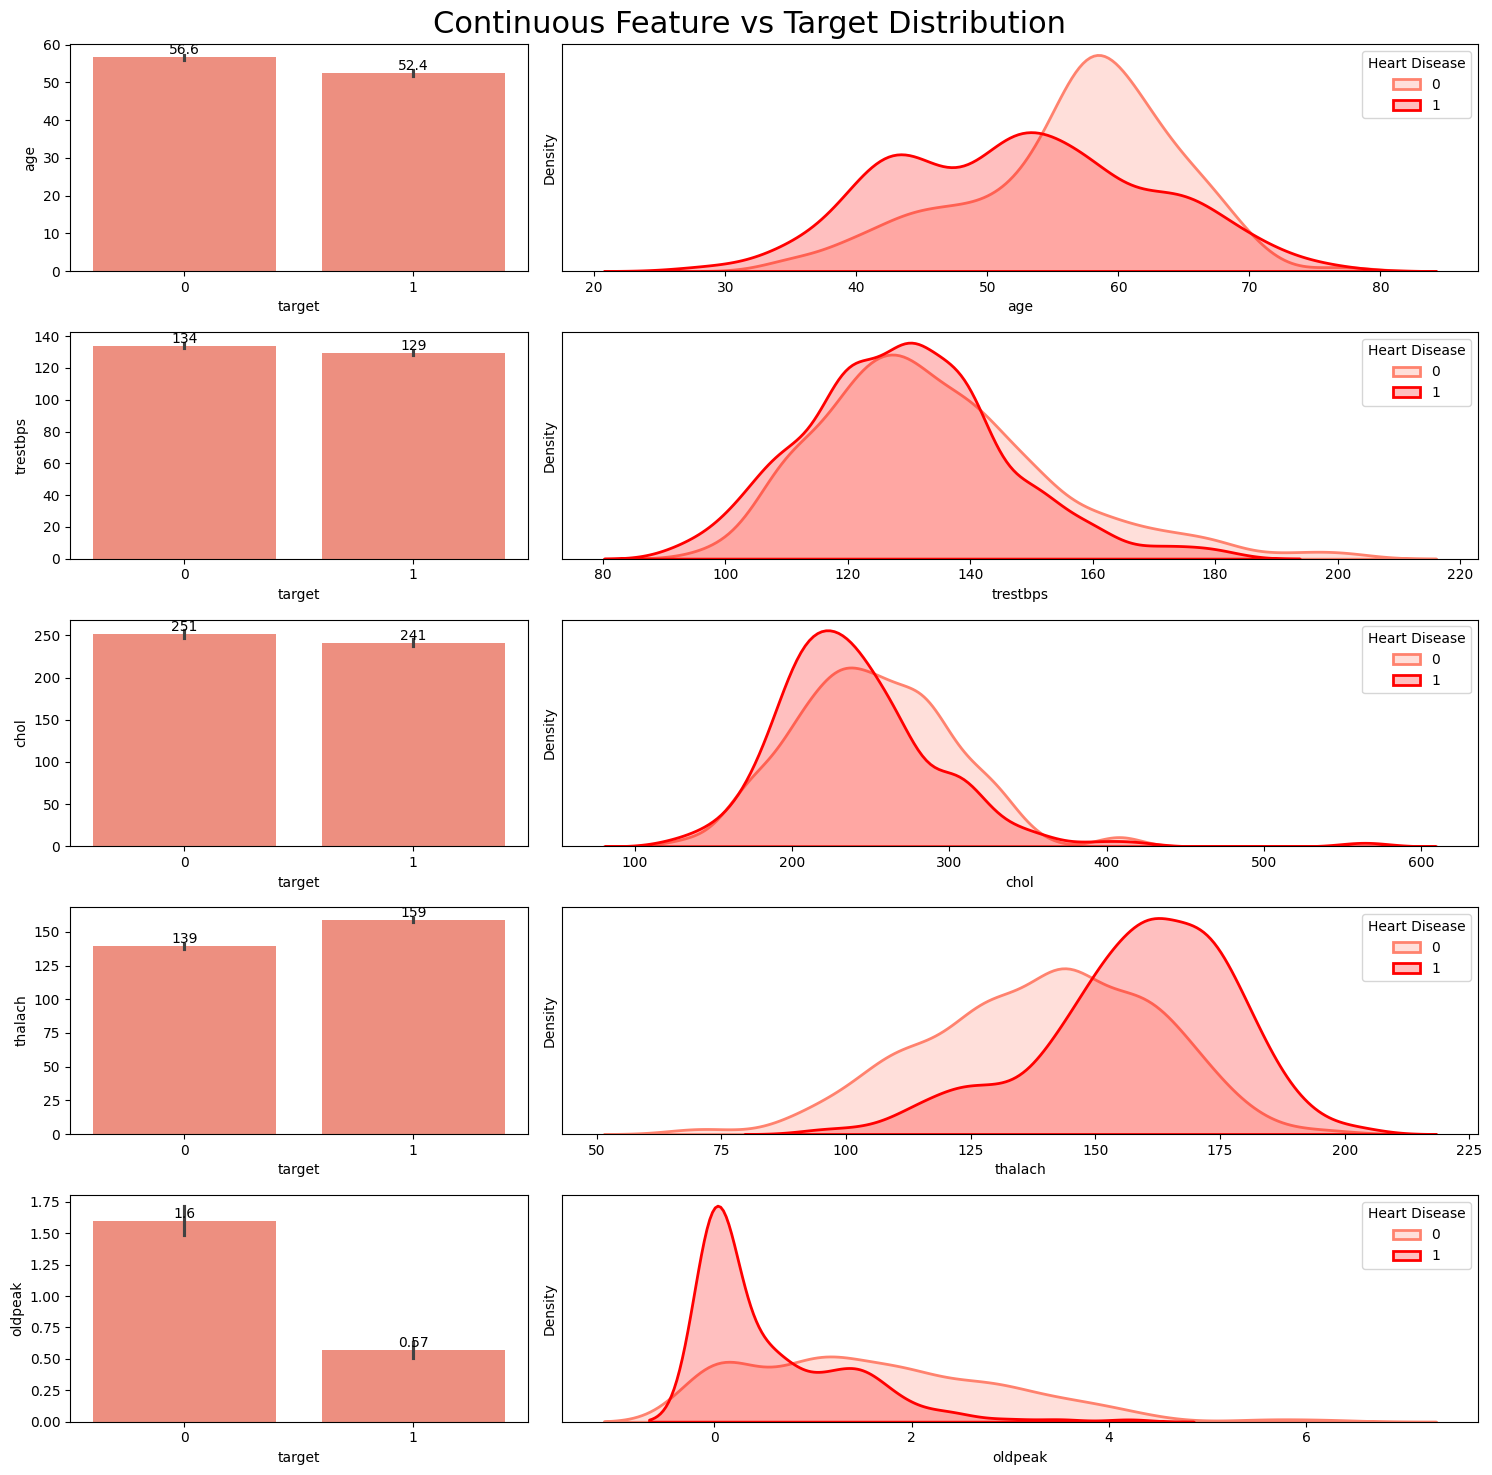

In [14]:
sns.set_palette(['#ff826e', 'red'])

fig, ax = plt.subplots(len(continuous_feature), 2, figsize=(15, 15), gridspec_kw={'width_ratios':[1, 2]})


for i, col in enumerate(continuous_feature):
  graph = sns.barplot(data=df, x="target", y=col, ax=ax[i, 0])

  sns.kdeplot(data=df[df["target"]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
  sns.kdeplot(data=df[df["target"]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
  ax[i,1].set_yticks([])
  ax[i, 1].legend(title='Heart Disease', loc='upper right')

  for cont in graph.containers:
    graph.bar_label(cont, fmt=             '%.3g')


plt.suptitle('Continuous Feature vs Target Distribution', fontsize=22)

plt.tight_layout()
plt.show()

In [15]:
Categorical_features = [feature for feature in Categorical_feature if feature != 'target'] # Changed categorical_features to Categorical_feature
Categorical_features

['ca', 'cp', 'exang', 'fbs', 'restecg', 'sex', 'slope', 'thal']

IndexError: index 4 is out of bounds for axis 0 with size 4

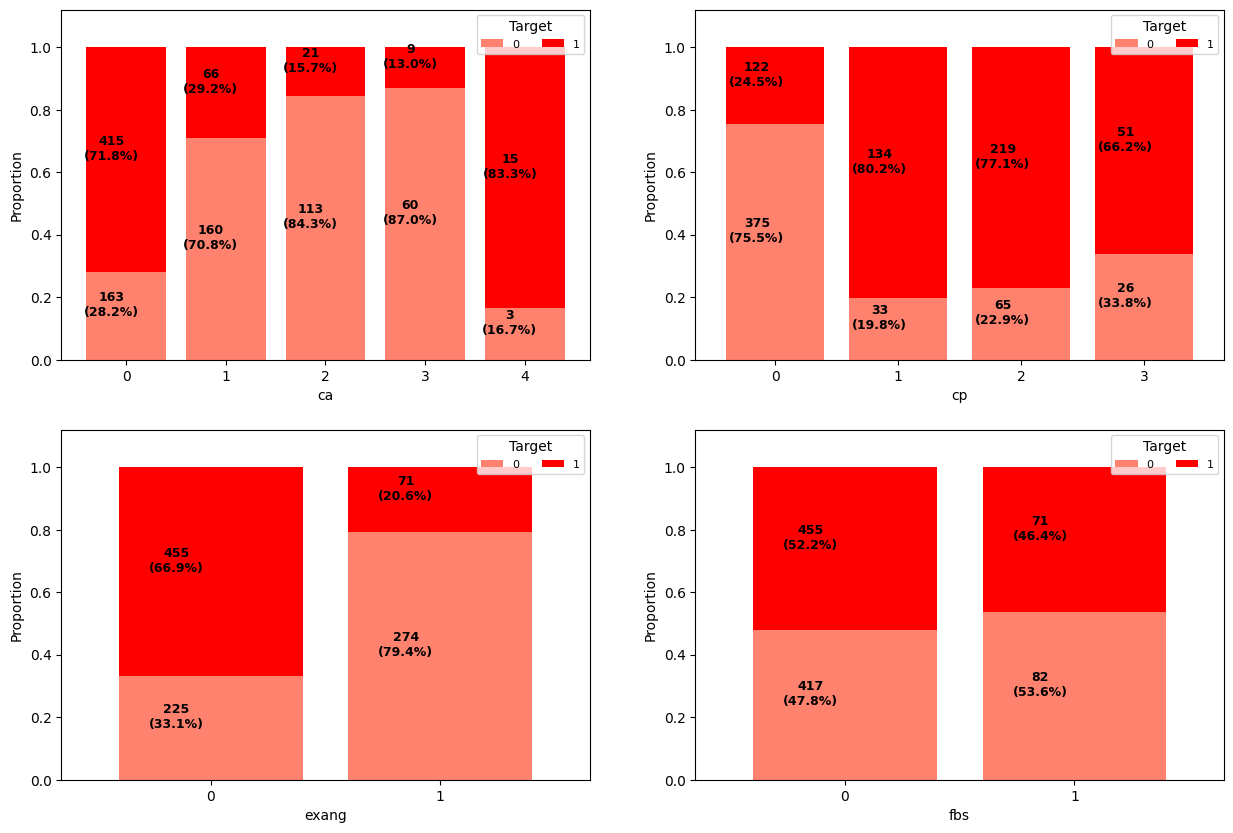

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
ax = ax.flatten()  # Flatten to simplify indexing (because you're using 4 subplots)

# Replace sns.categorical_feature with Categorical_features
for i, col in enumerate(Categorical_features):
    cross_tab = pd.crosstab(index=df[col], columns=df['target'])
    cross_tab_prop = pd.crosstab(index=df[col], columns=df['target'], normalize='index')

    cmp = ListedColormap(['#ff826e', 'red'])

    cross_tab_prop.plot(kind='bar', ax=ax[i], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion')

    for idx, val in enumerate(cross_tab.index):
        y_offset = 0
        for target_class in cross_tab.columns:
            count = cross_tab.loc[val, target_class]
            proportion = cross_tab_prop.loc[val, target_class]
            y_location = y_offset + proportion / 2
            ax[i].text(idx - 0.15, y_location, f'{count}\n({np.round(proportion*100, 1)}%)',
                       color="black", fontsize=9, fontweight="bold", ha='center')
            y_offset += proportion

    ax[i].legend(title='Target', loc='upper right', fontsize=8, ncol=2)
    ax[i].set_ylim([0, 1.12])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=0)

plt.suptitle('Categorical Feature vs Target - Stacked Barplots', fontsize=22)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the title
plt.show()

In [18]:
df.isnull().sum().sum()

np.int64(0)

In [19]:
continuous_feature

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [20]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [21]:
Q1 = df[continuous_feature].quantile(0.25)
Q3 = df[continuous_feature].quantile(0.75)
IQR = Q3 - Q1
outliers_count_specified = ((df[continuous_feature] < (Q1 - 1.5 * IQR)) | (df[continuous_feature] > (Q3 + 1.5 * IQR))).sum()
outliers_count_specified

,0
age,0
trestbps,30
chol,16
thalach,4
oldpeak,7


In [22]:
df_encoded = pd.get_dummies(df, columns=['cp', 'restecg', 'thal'], drop_first=True)

features_to_convert = ['sex', 'fbs', 'exang', 'slope', 'ca', 'target']
for features in features_to_convert:
    df_encoded[features] = df_encoded[features].astype('int')

df_encoded.dtypes


,0
age,int64
sex,int64
trestbps,int64
chol,int64
fbs,int64
thalach,int64
exang,int64
oldpeak,float64
slope,int64
ca,int64


In [23]:
df_encoded.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,52,1,125,212,0,168,0,1.0,2,2,0,False,False,False,True,False,False,False,True
1,53,1,140,203,1,155,1,3.1,0,0,0,False,False,False,False,False,False,False,True
2,70,1,145,174,0,125,1,2.6,0,0,0,False,False,False,True,False,False,False,True
3,61,1,148,203,0,161,0,0.0,2,1,0,False,False,False,True,False,False,False,True
4,62,0,138,294,1,106,0,1.9,1,3,0,False,False,False,True,False,False,True,False


In [24]:
for col in df_encoded.select_dtypes(include=['bool']).columns:
    df_encoded[col] = df_encoded[col].astype(int)

df_encoded.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
0,52,1,125,212,0,168,0,1.0,2,2,0,0,0,0,1,0,0,0,1
1,53,1,140,203,1,155,1,3.1,0,0,0,0,0,0,0,0,0,0,1
2,70,1,145,174,0,125,1,2.6,0,0,0,0,0,0,1,0,0,0,1
3,61,1,148,203,0,161,0,0.0,2,1,0,0,0,0,1,0,0,0,1
4,62,0,138,294,1,106,0,1.9,1,3,0,0,0,0,1,0,0,1,0


In [25]:
x = df_encoded.drop('target', axis=1)
y = df_encoded['target']

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0,stratify=y)

In [27]:
continuous_feature

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [28]:
x_train['oldpeak'] = x_train['oldpeak'] + 0.001
x_test['oldpeak'] = x_test['oldpeak'] + 0.001

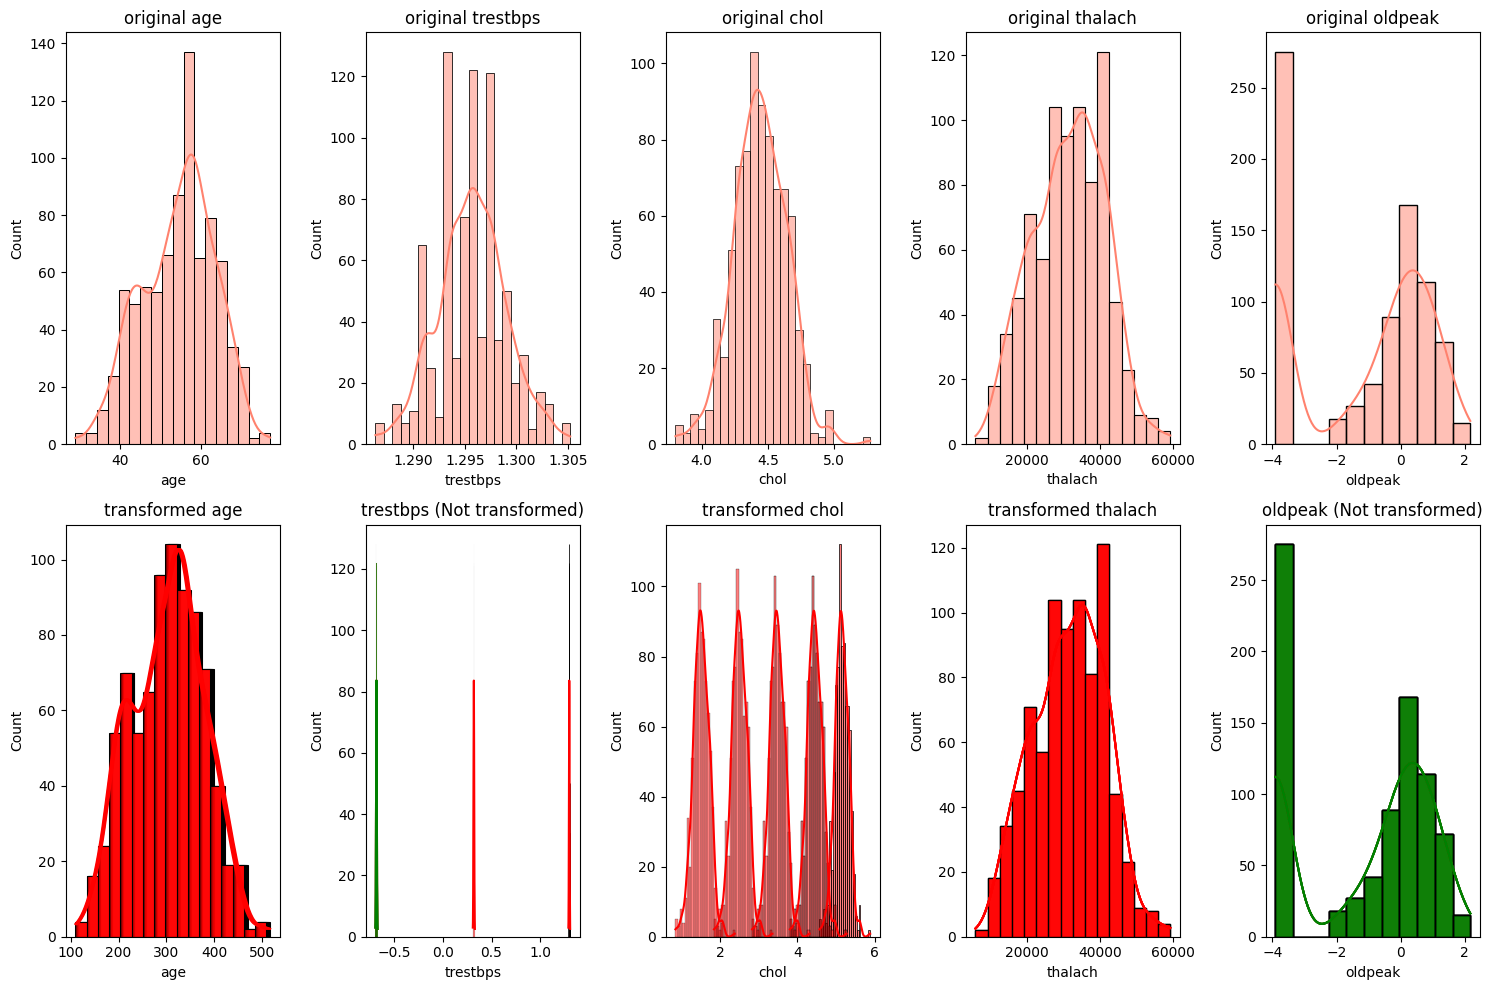

In [29]:
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
for i, col in enumerate(continuous_feature):
    sns.histplot(x_train[col], kde=True, ax=ax[0,i], color='#ff826e'). set_title(f'original {col}')



    lambdas = {}

    for i, col in enumerate(continuous_feature): # Changed continuous_features to continuous_feature

        if x_train[col].min() > 0:
           x_train[col], lambdas[col] = boxcox(x_train[col])

           # Use the calculated lambda to transform the test data
           x_test[col] = np.power(x_test[col], lambdas[col]) if lambdas[col] != 0 else np.log(x_test[col])
           sns.histplot(x_train[col], kde=True, ax=ax[1,i], color='red').set_title(f'transformed {col}')
        else: # Corrected indentation here
           sns.histplot(x_train[col], kde=True, ax=ax[1,i], color='green').set_title(f'{col} (Not transformed)')

fig.tight_layout() # Corrected indentation here
plt.show() # Corrected indentation here

In [30]:
x_train.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,cp_1,cp_2,cp_3,restecg_1,restecg_2,thal_1,thal_2,thal_3
397,183.135026,1,-0.683423,1.133517,0,16648.285611,1,0.739965,1,0,0,0,0,0,0,0,0,1
687,327.539594,1,-0.679372,1.733756,0,40973.525270,0,-3.905686,2,2,0,0,0,0,0,0,0,1
909,259.854044,1,-0.675312,1.318266,0,20793.213895,1,-0.103254,1,0,0,0,0,0,0,0,0,1
153,293.025595,1,-0.680624,1.579211,0,29283.605149,0,-0.840949,1,0,0,1,0,0,0,0,0,1
373,327.539594,1,-0.680624,1.677598,0,35348.214784,0,0.621445,1,0,1,0,0,0,0,0,1,0


In [31]:
dt_base = DecisionTreeClassifier(random_state=0)

In [32]:
def tune_clf_hyperparameters(clf, param_grid, x_train, y_train, scoring='recall', n_spilts=3):


  cv = StratifiedKFold(n_splits=n_spilts, shuffle=True, random_state=0)

  clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

  clf_grid.fit(x_train, y_train)

  # Assign best_hyperparameters to clf_grid.best_params_
  best_hyperparameters = clf_grid.best_params_

  return clf_grid.best_estimator_, best_hyperparameters

In [33]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3,],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2,]
}

In [34]:
best_dt, best_dt_hyperparparms = tune_clf_hyperparameters(dt_base, param_grid, x_train, y_train)

In [35]:
print('DT optimal best_hyperparameters:  \n', best_dt_hyperparparms)

DT optimal best_hyperparameters:  
 {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [36]:
print(classification_report(y_train, best_dt.predict(x_train)))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83       399
           1       0.84      0.85      0.85       421

    accuracy                           0.84       820
   macro avg       0.84      0.84      0.84       820
weighted avg       0.84      0.84      0.84       820



In [37]:
def evaluate_model(model, x_test, y_test, model_name):

  y_pred = model.predict(x_test)

  report = classification_report(y_test, y_pred, output_dict=True)

  metrices = {
      "precision_0": report["0"]["precision"],
      "precision_1": report["1"]["precision"],
      "recall_0": report["0"]["recall"],
      "recall_1": report["1"]["recall"],
      "f1_0": report["0"]["f1-score"],
      "f1_1": report["1"]["f1-score"],
      "macro_avg_precision": report["macro avg"]["precision"],
      "macro_avg_recall": report["macro avg"]["recall"],
      "macro_avg_f1": report["macro avg"]["f1-score"],
      "accuracy": accuracy_score(y_test, y_pred)
  }

  df = pd.DataFrame(metrices, index=[model_name].round(2))

  return df




In [38]:
def evaluate_model(model, x_test, y_test, model_name):

  y_pred = model.predict(x_test)

  report = classification_report(y_test, y_pred, output_dict=True)

  metrices = {
      "precision_0": report["0"]["precision"],
      "precision_1": report["1"]["precision"],
      "recall_0": report["0"]["recall"],
      "recall_1": report["1"]["recall"],
      "f1_0": report["0"]["f1-score"],
      "f1_1": report["1"]["f1-score"],
      "macro_avg_precision": report["macro avg"]["precision"],
      "macro_avg_recall": report["macro avg"]["recall"],
      "macro_avg_f1": report["macro avg"]["f1-score"],
      "accuracy": accuracy_score(y_test, y_pred)
  }

  # Changed from [model_name].round(2) to [model_name] to fix the error
  df = pd.DataFrame(metrices, index=[model_name])

  return df

In [39]:
dt_evaluation = evaluate_model(best_dt, x_test, y_test, 'DT')
dt_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
DT,0.90625,0.880734,0.87,0.914286,0.887755,0.897196,0.893492,0.892143,0.892476,0.892683


In [40]:
rf_base = RandomForestClassifier(random_state=0)

In [41]:
param_grid_rf = {
    'n_estimators': [10, 30, 50, 70, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True, False]
}

In [42]:
best_rf, best_rf_hyperparams = tune_clf_hyperparameters(rf_base, param_grid_rf, x_train, y_train)
print('RF optimal best_hyperparameters:  \n', best_rf_hyperparams)

RF optimal best_hyperparameters:  
 {'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [43]:
print(classification_report(y_train, best_rf.predict(x_train)))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       399
           1       0.87      0.93      0.90       421

    accuracy                           0.89       820
   macro avg       0.89      0.89      0.89       820
weighted avg       0.89      0.89      0.89       820



In [44]:
rf_evaluation = evaluate_model(best_rf, x_test, y_test, 'RF')
rf_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
RF,0.870968,0.830357,0.81,0.885714,0.839378,0.857143,0.850662,0.847857,0.848261,0.84878


  SVM BASE MODEL

In [45]:
from sklearn.pipeline import Pipeline # Import the Pipeline class
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

svm_pipeline = Pipeline([ # Change 'pipeline' to 'Pipeline'
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))
])

In [46]:
param_grid_svm = {
    'svm__C': [0.0011, 0.005, 0.01, 0.05, 0.1, 1, 10, 20], # Changed 'svm__c' to 'svm__C'
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': ['scale', 'auto', 0.1, 0.5, 1, 5],
    'svm__degree': [2, 3, 4]
}

In [47]:
best_svm, best_svm_hyperparams = tune_clf_hyperparameters(svm_pipeline, param_grid_svm, x_train, y_train)
print('SVM optimal best_hyperparameters:  \n', best_svm_hyperparams)

SVM optimal best_hyperparameters:  
 {'svm__C': 0.0011, 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}


In [48]:
print(classification_report(y_train, best_svm.predict(x_train)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       399
           1       0.51      1.00      0.68       421

    accuracy                           0.51       820
   macro avg       0.26      0.50      0.34       820
weighted avg       0.26      0.51      0.35       820



In [49]:
print(classification_report(y_test, best_svm.predict(x_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.51      1.00      0.68       105

    accuracy                           0.51       205
   macro avg       0.26      0.50      0.34       205
weighted avg       0.26      0.51      0.35       205



In [50]:
svm_evaluation = evaluate_model(best_svm, x_test, y_test, 'SVM')
svm_evaluation

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
SVM,0.0,0.512195,0.0,1.0,0.0,0.677419,0.256098,0.5,0.33871,0.512195


In [51]:
all_evaluation = ([dt_evaluation, rf_evaluation, svm_evaluation])
results = pd.concat(all_evaluation) # Changed 'all_evaluations' to 'all_evaluation'

results = results.sort_values(by='accuracy', ascending=False).round(2)
results

,precision_0,precision_1,recall_0,recall_1,f1_0,f1_1,macro_avg_precision,macro_avg_recall,macro_avg_f1,accuracy
DT,0.91,0.88,0.87,0.91,0.89,0.90,0.89,0.89,0.89,0.89
RF,0.87,0.83,0.81,0.89,0.84,0.86,0.85,0.85,0.85,0.85
SVM,0.00,0.51,0.00,1.00,0.00,0.68,0.26,0.50,0.34,0.51


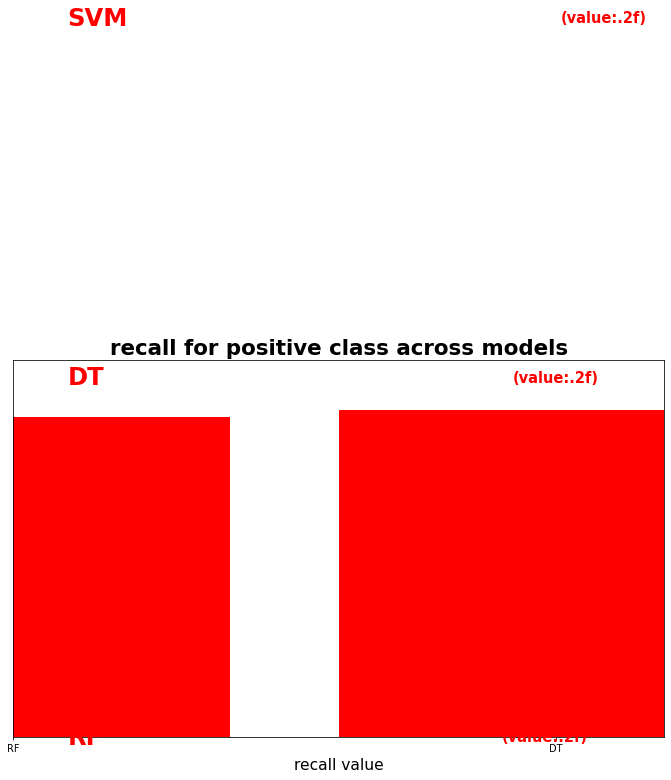

In [52]:
results = results.sort_values(by='recall_1', ascending=True)
recall_1_score = results['recall_1']

fig, ax = plt.subplots(figsize=(12, 7), dpi=70)
ax.bar(results.index, recall_1_score, color='red')

for i, (value, name) in enumerate(zip(recall_1_score, results.index)):
    ax.text(value + 0.01, i, f"(value:.2f)", ha='left', va='center', fontweight='bold', color='red', fontsize=15)
    ax.text(0.1, i, name, ha='left', va='center', fontweight='bold', color='red', fontsize=25)


    ax.set_yticks([])

    ax.set_xlim([0, 1.2])

    plt.title("recall for positive class across models", fontweight='bold', fontsize=22)
    plt.xlabel('recall value', fontsize=16)
plt.show()

In [53]:
import pickle

with open('best_svm_model.pkl', 'wb') as model_file:
  pickle.dump(best_svm, model_file)